# 1 Introduction

## 1.1 Building a network of mentions with tweets

In this notebook we will use Twitter data from the point of view of a network analysis. We are going to make a network of mentions using usernames from a tweet and the usernames mentioned. The network was built using tweets in Portuguese that contain the hashtag #covid19. For this, the Python programming language, Twitter API and necessary packages were used.

## 1.2 Twitter API

The Twitter API can be used to programmatically retrieve and analyze Twitter data, as well as build for the conversation on Twitter. Over the years, the Twitter API has grown by adding additional levels of access for developers and academic researchers to be able to scale their access to enhance and research the public conversation. 

## 1.3 Copyright

***Copyright:*** *Parts of the contents of this Colab Notebook, unless otherwise indicated, are Copyright 2020 Filippo Menczer, Santo Fortunato and Clayton A. Davis, [A First Course in Network Science](https://github.com/CambridgeUniversityPress/FirstCourseNetworkScience). All rights reserved.* 

***References***: getting started with the Twitter API v2 for academic research [here](https://github.com/twitterdev/getting-started-with-the-twitter-api-v2-for-academic-research). 


# 2 Authenticating with Twitter's API

Twitter uses OAuth in order to allow third-party apps to access data on your behalf without requiring your Twitter login credentials -- note that none of the code in this notebook asks for your Twitter screen name or password.

The OAuth "dance" can be intimidating when you first use it, but it provides a far more secure way for software to make requests on your behalf than providing your username and password.

We'll make use of the
[Twython](https://twython.readthedocs.io/en/latest/usage/starting_out.html#authentication)
package to help us with authentication and querying Twitter's APIs.

In [ ]:
!pip install Twython

In [ ]:
from twython import Twython, TwythonError

## 2.1 Enter app info and get auth URL

In order to authenticate with Twitter, we'll provide the app details and  ask for a one-time authorization URL to authenticate your user with this app.

Copy and paste the API key and secret from your Twitter app into a file named <font color="red">keys.txt</font>. The first line is the API_KEY and the second line of the file is API_SECRET_KEY. 

In [ ]:
# open the keys file
my_file = open("keys.txt", "r")

# read the raw data
content = my_file.read()

# split all lines by  newline character
API_KEY, API_SECRET_KEY = content.split("\n")

# close the file
my_file.close()

Executing the cell should then print out a clickable URL. This link is unique and will work **exactly** once. <font color="red"> Visit this URL, log into Twitter, and then copy the verifier pin that is given to you so as to paste it in the next step</font>.

In [ ]:
twitter = Twython(API_KEY, API_SECRET_KEY)

authentication_tokens = twitter.get_authentication_tokens()
print(authentication_tokens['auth_url'])

https://api.twitter.com/oauth/authenticate?oauth_token=_D-m2wAAAAABYwMeAAABfv7QHj0


## 2.2 Authorize app using verifier PIN

That verifier PIN goes into the next cell. This will be different every time you run these steps. The `authentication_tokens` include temporary tokens that go with this verifier PIN; by submitting these together, we show Twitter that we are who we say we are.

In [ ]:
# Replace the verifier with the pin number obtained with your web browser in the previous step
VERIFIER = '7435432'

twitter = Twython(API_KEY, API_SECRET_KEY,
                  authentication_tokens['oauth_token'],
                  authentication_tokens['oauth_token_secret'])

authorized_tokens = twitter.get_authorized_tokens(VERIFIER)

## 2.3 Use authorized tokens

Now we have a permanent token pair that we can use to make authenticated calls to the Twitter API. We'll create a new Twython object using these authenticated keys and verify the credentials of the logged-in user.

In [ ]:
twitter = Twython(API_KEY, API_SECRET_KEY,
                  authorized_tokens['oauth_token'],
                  authorized_tokens['oauth_token_secret'])

twitter.verify_credentials()

If the previous cell ran without error and printed out a dict corresponding to a
[Twitter User](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/user-object),
then you're good. The authorized token pair is like a username/password and should be protected as such.

# 3 Twitter Mention Network


A mention between users occurs when one user mentions another in a tweet by their @screen_name. As an example, consider the following tweet from @PhilSzostak:

> Love that this chart highlights George Lucas, @skywalkersound, and @ILMVFX...

From this tweet we would create two edges:

    ('PhilSzostak', 'skywalkersound')
    ('PhilSzostak', 'ILMVFX')

It's up to us which direction we draw these edges, but we should be consistent. In this example, we will draw edges in the direction of attention flow: @PhilSzostak is giving attention to @skywalkersound and @ILMVFX.


There are some rate limitations in order to use the Twitter API, you can see the current limits calling get_applicaiton_rate_limit_status()

In [ ]:
# current limits to search
twitter.get_application_rate_limit_status()['resources']["search"]

{'/search/tweets': {'limit': 180, 'remaining': 180, 'reset': 1644953479}}

## 3.1 Get some tweets

Twitter's
[Search API](https://developer.twitter.com/en/docs/tweets/search/api-reference/get-search-tweets.html)
allows you to fetch recent tweets according to a query of keywords, URLs, hashtags, user mentions, etc.

We'll make use of the ability to search by hashtags.

We can only fetch up to 100 tweets at a time from a single search API call. And we have 180 API calls every 15 minutes. With this, you can get up to 18000 tweets every 15 minutes. 

In order to get more than 100 tweets from a single search API call, we can make use of a cursor:

In [ ]:
import itertools

NUM_TWEETS_TO_FETCH = 1000
hashtag = '#covid19'

# tweets in portuguese containing the hashtag "#covid19"
cursor = twitter.cursor(twitter.search, q=hashtag, count=100, result_type='recent', lang='pt')
search_tweets = list(itertools.islice(cursor, NUM_TWEETS_TO_FETCH))

len(search_tweets)

1000

It's not necessary to first filter out tweets containing user mentions due to a feature of
[Tweet Objects](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object):
every tweet has
[Entities](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/entities-object#entitiesobject)
which always contains a `'user_mentions'` list, even if that list is empty. Since a tweet may mention more than one user, we need a nested for-loop.

Using pandas dataframe to store data:

In [ ]:
import pandas as pd

dict_ = {'username': [], 'mentioned': [], 'date': [], 'id': []}

for tweet in search_tweets:
    for user_mention in tweet['entities']['user_mentions']:
      dict_['username'].append(tweet['user']['screen_name'])
      dict_['mentioned'].append(user_mention['screen_name'])
      dict_['date'].append(tweet['created_at'])
      dict_['id'].append(tweet['id'])

df = pd.DataFrame(dict_)

print(df.shape)
df.tail()

(765, 4)


,username,mentioned,date,id
760,FlorDeserto,FlorDeserto,Mon Feb 14 18:39:03 +0000 2022,1493293728638853124
761,FlorDeserto,Edmar2310,Mon Feb 14 18:39:03 +0000 2022,1493293728638853124
762,FlorDeserto,Edmar2310,Mon Feb 14 18:38:57 +0000 2022,1493293701820555271
763,VGNoticias,minsaude,Mon Feb 14 18:33:44 +0000 2022,1493292390043602948
764,lourencyjr,opaisonline,Mon Feb 14 18:33:44 +0000 2022,1493292389892603904


Save dataframe in a csv file:

In [ ]:
import datetime

# Getting today's date
datestamp = datetime.datetime.now().strftime("%Y-%m-%d")

csv_filename = hashtag+"-"+datestamp+".csv"

df.to_csv(csv_filename, index=False)

## 3.2 Create DiGraph

In [ ]:
import networkx as nx

D = nx.DiGraph()

for index, row in df.iterrows():
    if D.has_edge(row['username'], row['mentioned']):
        D.edges[row['username'], row['mentioned']]['weight'] += 1
    else:
        D.add_edge(row['username'], row['mentioned'], weight=1)

In [ ]:
nx.write_graphml(D, "mentions.graphml")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 3.3 Analyze graph



Now that we have this graph, let's ask some questions about it.


### 3.3.1 Most  popular users



Since these edges are in the direction of attention flow, in-degree gives us the number of other users mentioning a given user. We can get the user with highest in-degree using the built-in `max` function:

In [ ]:
max(D.nodes, key=D.in_degree)

'contagemcorona1'

In [ ]:
usuario = twitter.show_user(screen_name='contagemcorona1')
print("""@{screen_name} has {followers_count} followers, follows {friends_count} users and has tweeted and retweeted {statuses_count} times.\n""".format(**usuario))
print("""@{screen_name} description:\n{description}\n""".format(**usuario))
print("""@{screen_name} status:\n{status}\n""".format(**usuario))

@contagemcorona1 has 35182 followers, follows 670 users and has tweeted and retweeted 38839 times.

@contagemcorona1 description:
Somos um coletivo mostrando o cenário real da pandemia no Brasil, com notícias atualizadas 24h.

Também mobilizamos e levamos doações a quem precisa.
Colabore!

@contagemcorona1 status:
{'created_at': 'Tue Feb 15 20:14:45 +0000 2022', 'id': 1493680199262781440, 'id_str': '1493680199262781440', 'text': '⚫SAO PAULO\n\nEstado registrou mais de 16 mil novos casos e 251 mortes por #Covid19 nas últimas 24h.\n\nTotal de vidas… https://t.co/odjQDGPYzS', 'truncated': True, 'entities': {'hashtags': [{'text': 'Covid19', 'indices': [73, 81]}], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/odjQDGPYzS', 'expanded_url': 'https://twitter.com/i/web/status/1493680199262781440', 'display_url': 'twitter.com/i/web/status/1…', 'indices': [116, 139]}]}, 'source': '<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>', 'in_reply_

we can get more context and information from the top 5 users:

In [ ]:
from operator import itemgetter

sorted(D.in_degree(), key=itemgetter(1), reverse=True)[:5]

[('contagemcorona1', 54),
 ('mqueiroga2', 26),
 ('SSalud_mx', 25),
 ('tvsenado', 24),
 ('randolfeap', 22)]

By specifying `weight='weight'` we can instead get the top 5 users by in-strength instead of in-degree:

In [ ]:
sorted(D.in_degree(weight='weight'), key=itemgetter(1), reverse=True)[:5]

[('contagemcorona1', 113),
 ('mqueiroga2', 26),
 ('SSalud_mx', 25),
 ('tvsenado', 24),
 ('randolfeap', 22)]

In some cases these two results will be the same, namely if none of these users has been mentioned multiple times by the same user. Depending on your use case, you may or may not wish to take the weights into account.


### 3.3.2 Conversation drivers



A user mentioning many others in a conversation may be "driving" the conversation and trying to include others in the dialogue. It could also be spam. Let's see who is doing the most mentioning here:

In [ ]:
sorted(D.out_degree(weight='weight'), key=itemgetter(1), reverse=True)[:5]

[('Bot_Corona_V', 112),
 ('denio_vale', 35),
 ('BrazilSFE', 20),
 ('Mulher_Noticia', 14),
 ('levycorreia', 8)]

In [ ]:
usuario = twitter.show_user(screen_name='Bot_Corona_V')
print("""@{screen_name} has {followers_count} followers, follows {friends_count} users and has tweeted and retweeted {statuses_count} times.\n""".format(**usuario))
print("""@{screen_name} description:\n{description}\n""".format(**usuario))
print("""@{screen_name} status:\n{status}\n""".format(**usuario))

@Bot_Corona_V has 2767 followers, follows 9 users and has tweeted and retweeted 408836 times.

@Bot_Corona_V description:
Apenas um bot que retweeta assuntos com relação ao COVID-19.

@Bot_Corona_V status:
{'created_at': 'Tue Feb 15 20:11:31 +0000 2022', 'id': 1493679386918330373, 'id_str': '1493679386918330373', 'text': 'RT @RICMais_: Covid: PR completa um mês de vacinação infantil e especialistas reforçam importância #RICMais #coronavirus\nhttps://t.co/ivUnB…', 'truncated': False, 'entities': {'hashtags': [{'text': 'RICMais', 'indices': [99, 107]}, {'text': 'coronavirus', 'indices': [108, 120]}], 'symbols': [], 'user_mentions': [{'screen_name': 'RICMais_', 'name': 'RIC Mais', 'id': 389031552, 'id_str': '389031552', 'indices': [3, 12]}], 'urls': []}, 'source': '<a href="https://github.com/snowlew" rel="nofollow">Alpha-sun</a>', 'in_reply_to_status_id': None, 'in_reply_to_status_id_str': None, 'in_reply_to_user_id': None, 'in_reply_to_user_id_str': None, 'in_reply_to_screen_name': None

### 3.3.3 Connectivity



We can ask if the tweets obtained by the search represent one large conversation or many small conversations; broadly speaking, each weakly-connected component represents a conversation.

In [ ]:
nx.is_weakly_connected(D)

False

In [ ]:
nx.number_weakly_connected_components(D)

90

## 3.4 Drawing



We can try to draw this graph with the nodes sized by their out-strength:

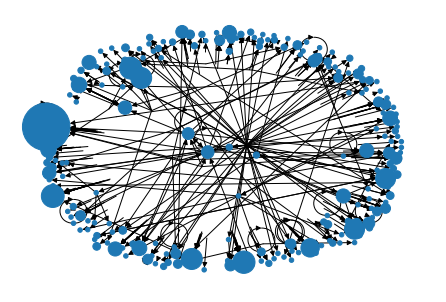

In [ ]:
node_sizes = [D.in_degree(n, weight='weight') * 20 for n in D.nodes]

%matplotlib inline
nx.draw(D, node_size=node_sizes)

# 4 Collecting data for a week

The 'data' folder has csv files with mentions of users on twitter in the hashtag #covid19 in tweets in portuguese during the period of one week.

Reading all csv files from the folder and turning them all into a single dataframe:

In [ ]:
#using google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import glob

path = '/content/drive/MyDrive/Colab Notebooks/data' # use your path

all_files = glob.glob(path + "/*.csv")

df = pd.concat((pd.read_csv(f) for f in all_files))

print(df.shape)
df.head(10)


(11065, 4)


,username,mentioned,date,id
0,Mulher_Noticia,contagemcorona1,Wed Feb 09 23:59:05 +0000 2022,1491562326239195144
1,Bot_Corona_V,BrazilSFE,Wed Feb 09 23:58:42 +0000 2022,1491562229854048257
2,Bot_Corona_V,merial,Wed Feb 09 23:58:42 +0000 2022,1491562229854048257
3,Bot_Corona_V,kineta,Wed Feb 09 23:58:42 +0000 2022,1491562229854048257
4,BrazilSFE,merial,Wed Feb 09 23:58:08 +0000 2022,1491562087931330561
5,BrazilSFE,kineta,Wed Feb 09 23:58:08 +0000 2022,1491562087931330561
6,Mulher_Noticia,contagemcorona1,Wed Feb 09 23:57:38 +0000 2022,1491561962471309312
7,Mulher_Noticia,contagemcorona1,Wed Feb 09 23:54:29 +0000 2022,1491561168661581825
8,faconti,brasil_io,Wed Feb 09 23:54:12 +0000 2022,1491561096972574732
9,FreitasLuizete,contagemcorona1,Wed Feb 09 23:48:48 +0000 2022,1491559738504531969


# 4.1 Create DiGraph

In [ ]:
import networkx as nx

D = nx.DiGraph()

for index, row in df.iterrows():
    if D.has_edge(row['username'], row['mentioned']):
        D.edges[row['username'], row['mentioned']]['weight'] += 1
    else:
        D.add_edge(row['username'], row['mentioned'], weight = 1)

In [ ]:
print("The graph has {} nodes and {} edges".format(len(D), nx.number_of_edges(D)))

The graph has 4508 nodes and 5815 edges


In [ ]:
nx.write_graphml(D, "twiter_covid19_mentions.graphml")

## 4.2 Analyze graph



Now that we have this graph, let's ask some questions about it.


### 4.2.1 Most  popular users


Since these edges are in the direction of attention flow, in-degree gives us the number of other users mentioning a given user. We can get the user with highest in-degree using the built-in `max` function:

In [ ]:
max(D.nodes, key=D.in_degree)

'AiltonBenedito'


we can get more context and information from the top 5 users:

In [ ]:
from operator import itemgetter

listsorted = sorted(D.in_degree(), key=itemgetter(1), reverse=True)[:5]
listsorted

[('AiltonBenedito', 596),
 ('contagemcorona1', 583),
 ('mqueiroga2', 218),
 ('jdoriajr', 179),
 ('Arthurvneto', 167)]

In [ ]:
users = [i[0] for i in listsorted]
for user in users:
    usuario = twitter.show_user(screen_name=user)
    print("""@{screen_name} has {followers_count} followers, follows {friends_count} users and has tweeted and retweeted {statuses_count} times.""".format(**usuario))
    print("""@{screen_name} description:\n{description}""".format(**usuario))
    print("-" * 120)

@contagemcorona1 has 35179 followers, follows 670 users and has tweeted and retweeted 38839 times.
@contagemcorona1 description:
Somos um coletivo mostrando o cenário real da pandemia no Brasil, com notícias atualizadas 24h.

Também mobilizamos e levamos doações a quem precisa.
Colabore!
------------------------------------------------------------------------------------------------------------------------
@AiltonBenedito has 247652 followers, follows 1194 users and has tweeted and retweeted 73732 times.
@AiltonBenedito description:
"O Senhor é meu pastor, nada me faltará."
------------------------------------------------------------------------------------------------------------------------
@merial has 2 followers, follows 0 users and has tweeted and retweeted 1 times.
@merial description:
Merial is now part of Boehringer Ingelheim. Follow us on @Boehringer_AH for  company news and related #AnimalHealth info.
---------------------------------------------------------------------------

By specifying `weight='weight'` we can instead get the top 5 users by in-strength instead of in-degree:

In [ ]:
listsorted = sorted(D.in_degree(weight='weight'), key=itemgetter(1), reverse=True)[:5]
listsorted

[('contagemcorona1', 1929),
 ('AiltonBenedito', 635),
 ('merial', 345),
 ('MiguelNicolelis', 342),
 ('adaopaiani', 294)]

In [ ]:
users = [i[0] for i in listsorted]
for user in users:
    usuario = twitter.show_user(screen_name=user)
    print("""@{screen_name} has {followers_count} followers, follows {friends_count} users and has tweeted and retweeted {statuses_count} times.""".format(**usuario))
    print("""@{screen_name} description:\n{description}""".format(**usuario))
    print("-" * 120)

@contagemcorona1 has 35182 followers, follows 670 users and has tweeted and retweeted 38839 times.
@contagemcorona1 description:
Somos um coletivo mostrando o cenário real da pandemia no Brasil, com notícias atualizadas 24h.

Também mobilizamos e levamos doações a quem precisa.
Colabore!
------------------------------------------------------------------------------------------------------------------------
@AiltonBenedito has 247652 followers, follows 1194 users and has tweeted and retweeted 73732 times.
@AiltonBenedito description:
"O Senhor é meu pastor, nada me faltará."
------------------------------------------------------------------------------------------------------------------------
@merial has 2 followers, follows 0 users and has tweeted and retweeted 1 times.
@merial description:
Merial is now part of Boehringer Ingelheim. Follow us on @Boehringer_AH for  company news and related #AnimalHealth info.
---------------------------------------------------------------------------

In some cases these two results will be the same, namely if none of these users has been mentioned multiple times by the same user. Depending on your use case, you may or may not wish to take the weights into account.


### 4.2.2 Conversation drivers



A user mentioning many others in a conversation may be "driving" the conversation and trying to include others in the dialogue. It could also be spam. Let's see who is doing the most mentioning here:

In [ ]:
listsorted = sorted(D.out_degree(weight='weight'), key=itemgetter(1), reverse=True)[:5]
listsorted

[('Bot_Corona_V', 1529),
 ('denio_vale', 1002),
 ('BrazilSFE', 408),
 ('nicolaskasprzak', 268),
 ('viralvideovlogs', 264)]

In [ ]:
users = [i[0] for i in listsorted]
for user in users:
    usuario = twitter.show_user(screen_name=user)
    print("""@{screen_name} has {followers_count} followers, follows {friends_count} users and has tweeted and retweeted {statuses_count} times.""".format(**usuario))
    print("""@{screen_name} description:\n{description}""".format(**usuario))
    print("-" * 120)

@contagemcorona1 has 35182 followers, follows 670 users and has tweeted and retweeted 38839 times.
@contagemcorona1 description:
Somos um coletivo mostrando o cenário real da pandemia no Brasil, com notícias atualizadas 24h.

Também mobilizamos e levamos doações a quem precisa.
Colabore!
------------------------------------------------------------------------------------------------------------------------
@AiltonBenedito has 247653 followers, follows 1194 users and has tweeted and retweeted 73732 times.
@AiltonBenedito description:
"O Senhor é meu pastor, nada me faltará."
------------------------------------------------------------------------------------------------------------------------
@merial has 2 followers, follows 0 users and has tweeted and retweeted 1 times.
@merial description:
Merial is now part of Boehringer Ingelheim. Follow us on @Boehringer_AH for  company news and related #AnimalHealth info.
---------------------------------------------------------------------------

### 4.2.3 Connectivity



We can ask if the tweets obtained by the search represent one large conversation or many small conversations; broadly speaking, each weakly-connected component represents a conversation.

In [ ]:
nx.is_weakly_connected(D)

False

In [ ]:
nx.number_weakly_connected_components(D)

266

### 4.2.4 Drawing



We can try to draw this graph with the nodes sized by their out-strength:

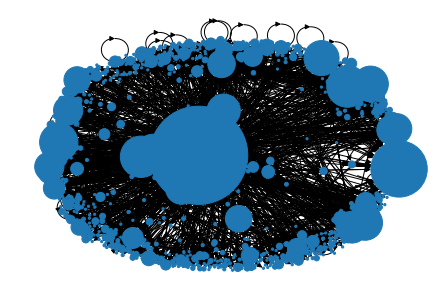

In [ ]:
node_sizes = [D.in_degree(n, weight='weight') * 5 for n in D.nodes]

%matplotlib inline
nx.draw(D, node_size=node_sizes)